In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import shap
from sklearn.metrics import confusion_matrix, classification_report

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

d:\WORKSPACE_CS\LJMU_Research\other\dash\health_policy_recomendation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
df = pd.read_csv("D:/WORKSPACE_CS/LJMU_Research/other/dash/health_policy_recomendation/src/health_policy_recomendation/data/ushealthinsurance.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [45]:
# By integrating business logic and focusing on interpretability through rule-based modeling, 
# this approach offers a valuable learning opportunity by simulating realistic insurance company selection 
# based on domain knowledge and industry patterns.

import random

def assign_company(row):
    # High-risk, premium-focused company
    if row['smoker'] == 'yes' or row['bmi'] > 35:
        return 'Company A'
    
    # Family-oriented, northeast/northwest regional focus
    elif row['children'] >= 2 and (row['region'] in ['northeast', 'northwest']):
        return 'Company B'
    
    # Senior-focused, value company
    elif row['age'] > 50 and row['charges'] < 15000:
        return 'Company C'
    
    # Young adult, southern regions
    else:
        return 'Company D'
    

# def assign_company(row):
    # # High-risk, premium-focused company
    # if row['smoker'] == 'yes' or row['bmi'] > 35:
    #     return 'Company A'
    
    # # Family-oriented, northeast/northwest regional focus
    # elif row['children'] >= 2 and (row['region'] in ['northeast', 'northwest']) or (row['age'] < 30):
    #     return 'Company B'
    
    # # Senior-focused, value company, Female-oriented
    # elif row['age'] > 50 and row['charges'] < 15000 or row['sex'] == 'female':
    #     return 'Company C'
    
    # # Young adult, southern regions
    # else:
    #     return 'Company D'


def assign_company_with_noise(row):
    # Get the deterministic assignment
    base_company = assign_company(row)
    
    # Add 10% chance of switching to a different company
    if random.random() < 0.10:
        all_companies = ['Company A', 'Company B', 'Company C', 'Company D']
        other_companies = [c for c in all_companies if c != base_company]
        return random.choice(other_companies)
    else:
        return base_company
    

df['insurance_company'] = df.apply(assign_company_with_noise, axis=1)

In [3]:
import random

# Version 3: Attempting to increase importance of sex and region
def assign_company_complex(row):
    # --- Company A: High Risk Focus ---
    # Added a rule specifically for younger male smokers
    if row['smoker'] == 'yes':
        if row['bmi'] > 32 or row['age'] > 55:
             return 'Company A'
        # NEW RULE A1: Target younger male smokers explicitly
        elif row['sex'] == 'male' and row['age'] < 40:
             # Give younger male smokers a direct path to A
             return 'Company A'
    elif row['bmi'] > 40: # High BMI check (largely unchanged)
         return 'Company A'

    # --- Company B: Established / Family Focused / Regional ---
    # Original rule using NW/SW region remains
    elif row['smoker'] == 'no' and row['children'] >= 2:
        if (row['region'] in ['northwest', 'southwest']) and (35 <= row['age'] <= 60):
             return 'Company B'
        # Modified the "any region" rule slightly - perhaps make it female-biased?
        elif row['bmi'] < 30 and row['age'] < 50 and row['sex'] == 'female': # MODIFIED: Added sex condition
             return 'Company B'

    # --- Company C: Younger / Health-Conscious / Individual ---
    # Added a region-specific rule (Northeast)
    elif row['smoker'] == 'no' and row['age'] < 35:
        # NEW RULE C1: Region NE focus for young individuals without children
        if row['region'] == 'northeast' and row['children'] == 0:
            return 'Company C'
        # Rule C2 (Original v2 Rule C1 - Relaxed BMI/children)
        elif row['children'] <= 1 and row['bmi'] < 27:
             return 'Company C'
        # Rule C3 (Original v2 Rule C2 - Female bias - unchanged)
        elif row['children'] <= 1 and row['bmi'] < 28 and row['sex'] == 'female':
             return 'Company C'

    # --- Company D: Older / Lower-Risk Individuals / Other ---
    # Added region (SE) and sex (female) specific conditions
    elif row['smoker'] == 'no' and row['age'] > 62:
         # Rule D1a: Added explicit female condition for older group
         if row['bmi'] < 33 and row['sex'] == 'female':
              return 'Company D'
         # Rule D1b: Original rule now mainly applies to males or those failing D1a
         elif row['bmi'] < 33:
              return 'Company D'
    # NEW RULE D2: Region SE focus for middle-aged/older non-smokers
    elif row['smoker'] == 'no' and row['region'] == 'southeast' and row['age'] >= 40:
         return 'Company D'
    # Rule D3: Original male-focused rule (unchanged)
    elif row['smoker'] == 'no' and row['sex'] == 'male' and row['children'] <= 1 and row['age'] >= 35:
         return 'Company D'

    # --- Fallback ---
    # Assigns remaining profiles to D.
    else:
        return 'Company D'

# --- Function to add noise (use the same one as before) ---
def assign_company_with_noise(row, noise_level=0.10):
    base_company = assign_company_complex(row)
    if random.random() < noise_level:
        all_companies = ['Company A', 'Company B', 'Company C', 'Company D']
        other_companies = [c for c in all_companies if c != base_company]
        if other_companies:
             return random.choice(other_companies)
        else:
             return base_company
    else:
        return base_company


df['insurance_company'] = df.apply(assign_company_with_noise, axis=1)

In [4]:
df['insurance_company'].value_counts(normalize=True)

insurance_company
Company D    0.389418
Company A    0.264550
Company B    0.178836
Company C    0.167196
Name: proportion, dtype: float64

In [5]:
# Convert categorical columns to numerical
le = LabelEncoder()
df['insurance_company'] = le.fit_transform(df['insurance_company'])

In [6]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'insurance_company'],
      dtype='object')

In [7]:
from imblearn.over_sampling import SMOTE

# Step 3: Drop original charges column
X = df.drop(['insurance_company', 'charges'], axis=1)

# X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_encoded = pd.get_dummies(X, columns=['sex','smoker','region'], drop_first=True)

# Step 5: Train classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = df['insurance_company']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train on balanced data
model.fit(X_resampled, y_resampled)

# model.fit(X_train, y_train)

# Evaluate
accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.8627


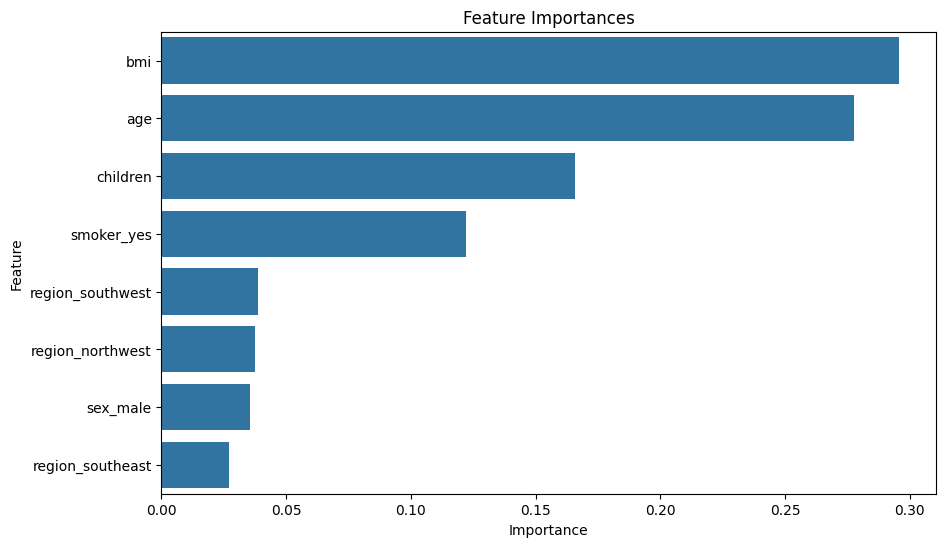

In [8]:
# Feature importance

importances = model.feature_importances_

# Create a DataFrame for feature importances

importances_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [73]:
importances_df

,Feature,Importance
1,bmi,0.293858
0,age,0.285525
2,children,0.155309
4,smoker_yes,0.125333
7,region_southwest,0.039178
3,sex_male,0.035775
5,region_northwest,0.034252
6,region_southeast,0.030769


In [23]:
# Convert categorical columns to numerical
categorical_cols = ['sex', 'smoker', 'region', 'insurance_company']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store the encoder for later inverse transform

In [75]:
# 1. Create Insurance Company assignments using all data including charges
from sklearn.ensemble import RandomForestClassifier

# 2. Train model WITHOUT using charges
X = df.drop(['insurance_company', 'charges'], axis=1)  # Remove both target and charges
y = df['insurance_company']

# 3. Encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# 4. Train classifier
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

Accuracy: 0.8395522388059702
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        51
           1       0.74      0.76      0.75        33
           2       1.00      0.52      0.68        33
           3       0.79      0.96      0.86        70
           4       0.89      0.88      0.88        81

    accuracy                           0.84       268
   macro avg       0.86      0.80      0.81       268
weighted avg       0.85      0.84      0.83       268



In [5]:
# Feedback based on logical rules
charges_scaled = df['charges'] / df['charges'].max()
df['feedback'] = (
    (5 - charges_scaled * 5) + 
    (df['smoker'].map({1: -1, 0: 1})) +  # 1 = yes, 0 = no
    df['bmi'].apply(lambda x: 1 if x < 25 else -1)
)
df['feedback'] = df['feedback'].clip(0, 5)

In [7]:
# # Normalize numerical columns
# scaler = MinMaxScaler()    # earlier StandardScaler was used.
# df[['age', 'bmi', 'children', 'charges']] = scaler.fit_transform(df[['age', 'bmi', 'children', 'charges']])

# # Display processed dataset
# df.head()

In [6]:
scaler = MinMaxScaler()
df['feedback_scaled'] = scaler.fit_transform(df[['feedback']])
df['charges_scaled'] = scaler.fit_transform(df[['charges']])

# Utility Score = weighted sum of scaled metrics
df['utility_score'] = 0.6 * df['feedback_scaled'] + 0.4 * (1 - df['charges_scaled'])

In [ ]:
#Step 5: Utility-Based Recommendation System

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1338 non-null   int64  
 1   sex                1338 non-null   int32  
 2   bmi                1338 non-null   float64
 3   children           1338 non-null   int64  
 4   smoker             1338 non-null   int32  
 5   region             1338 non-null   int32  
 6   charges            1338 non-null   float64
 7   User ID            1338 non-null   int64  
 8   Insurance Company  1338 non-null   int32  
 9   feedback           1338 non-null   float64
 10  feedback_scaled    1338 non-null   float64
 11  charges_scaled     1338 non-null   float64
 12  utility_score      1338 non-null   float64
dtypes: float64(6), int32(4), int64(3)
memory usage: 115.1 KB


In [8]:
# Show top recommendations
df[['age', 'bmi', 'smoker', 'charges', 'feedback', 'utility_score']].sort_values(by="utility_score", ascending=True).head(10)

,age,bmi,smoker,charges,feedback,utility_score
543,54,47.410,1,63770.42801,0.0,4.440892e-17
1300,45,30.360,1,62592.87309,0.0,7.518481e-03
1230,52,34.485,1,60021.39897,0.0,2.393689e-02
577,31,38.095,1,58571.07448,0.0,3.319696e-02
819,33,35.530,1,55135.40209,0.0,5.513312e-02
1146,60,32.800,1,52590.82939,0.0,7.137977e-02
34,28,36.400,1,51194.55914,0.0,8.029471e-02
1241,64,36.960,1,49577.66240,0.0,9.061831e-02
1062,59,41.140,1,48970.24760,0.0,9.449655e-02
488,44,38.060,1,48885.13561,0.0,9.503997e-02


In [9]:
# Group by insurance company & average feedback score
feedback_profile = df.groupby('insurance_company')['feedback'].mean().reset_index()
feedback_profile.columns = ['insurance_company', 'avg_feedback_score']

# Merge back to data — acts like a "reputation score"
df = df.merge(feedback_profile, on='insurance_company', how='left')

In [10]:
df.head()

,age,sex,bmi,children,smoker,region,charges,User ID,Insurance Company,feedback,feedback_scaled,charges_scaled,utility_score,avg_feedback_score
0,19,0,27.900,0,1,3,16884.92400,1,3,1.676116,0.335223,0.251611,0.500490,3.755393
1,18,1,33.770,1,0,2,1725.55230,2,4,4.864706,0.972941,0.009636,0.979910,3.781570
2,28,1,33.000,3,0,2,4449.46200,3,4,4.651134,0.930227,0.053115,0.936890,3.781570
3,33,1,22.705,0,0,1,21984.47061,4,0,5.000000,1.000000,0.333010,0.866796,3.789457
4,32,1,28.880,0,0,1,3866.85520,5,2,4.696814,0.939363,0.043816,0.946092,3.779758


In [11]:
df.describe()

,age,sex,bmi,children,smoker,region,charges,User ID,Insurance Company,feedback,feedback_scaled,charges_scaled,utility_score,avg_feedback_score
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1.338000e+03,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265,669.500000,1.967862,3.750871,0.750174,0.193916,7.725382e-01,3.750871
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237,386.391641,1.456325,1.555921,0.311184,0.193301,2.601994e-01,0.055322
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900,1.000000,0.000000,0.000000,0.000000,0.000000,4.440892e-17,3.639367
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150,335.250000,1.000000,3.744793,0.748959,0.057757,7.543233e-01,3.755393
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000,669.500000,2.000000,4.345697,0.869139,0.131849,8.723978e-01,3.779758
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515,1003.750000,3.000000,4.762632,0.952526,0.247700,9.451240e-01,3.781570
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010,1338.000000,4.000000,5.000000,1.000000,1.000000,1.000000e+00,3.789457


In [ ]:
#Step 2: Exploratory Data Analysis (EDA)

In [ ]:
#2.1 Feature Correlations

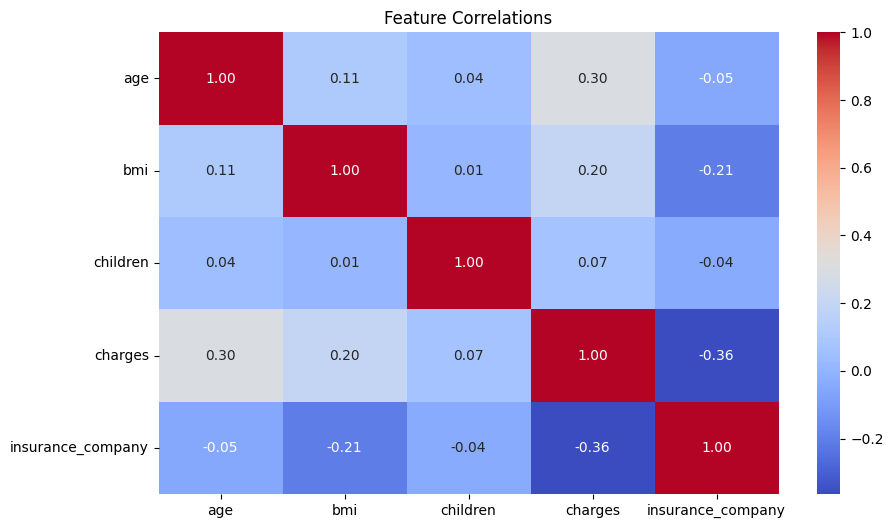

In [76]:
# Compute correlation matrix
correlation_matrix = df.select_dtypes(include=np.number).corr()

# Heatmap for visualization
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations")
plt.show()

In [ ]:
#Step 3: Data Visualization & Feature Relationships

In [ ]:
#3.1 Age vs Charges

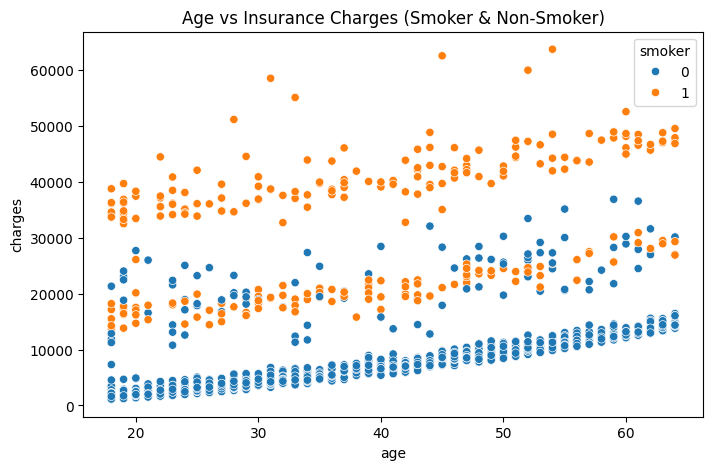

In [15]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["age"], y=df["charges"], hue=df["smoker"])
plt.title("Age vs Insurance Charges (Smoker & Non-Smoker)")
plt.show()

In [ ]:
#3.2 Smoker Impact on Charges

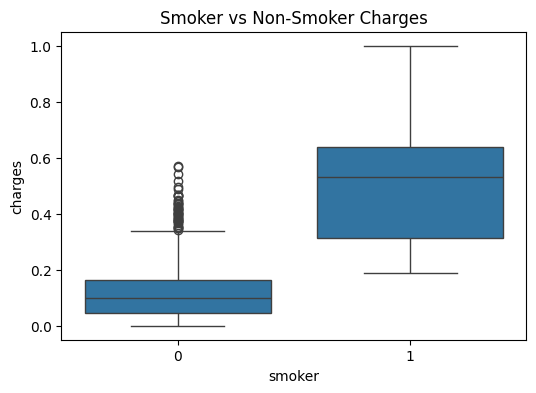

In [15]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["smoker"], y=df["charges"])
plt.title("Smoker vs Non-Smoker Charges")
plt.show()


In [ ]:
#Step 6: Machine Learning Model Training & Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

X = encoded_df.drop('insurance_company', axis=1)
y = df['insurance_company']

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
scores = cross_val_score(rf, X, y, cv=skf, scoring='accuracy')
print(f"Cross-validation accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                              n_iter=20, cv=skf, verbose=2, random_state=42, 
                              scoring='accuracy')
rf_random.fit(X, y)
print(f"Best parameters: {rf_random.best_params_}")
print(f"Best accuracy: {rf_random.best_score_:.4f}")

In [ ]:
# Train best model
best_model = rf_random.best_estimator_

# Feature importance
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance.head(10))

In [ ]:
#6.1 Split Data

In [23]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'User ID', 'Insurance Company', 'feedback', 'feedback_scaled',
       'charges_scaled', 'utility_score', 'avg_feedback_score'],
      dtype='object')

In [21]:
# Drop unnecessary columns
# X = df.drop(columns=["User ID", "Insurance Company", "feedback_scaled", "charges_scaled"])
X = df[["avg_feedback_score"]]

# Define target variable
y = df["insurance_company"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Train a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

# Make predictions

y_pred = rf.predict(X_test)

In [23]:
# Evaluate the model

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        56
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        55

    accuracy                           1.00       268
   macro avg       1.00      1.00      1.00       268
weighted avg       1.00      1.00      1.00       268



In [23]:
# Feature importance

importances = rf.feature_importances_

# Create a DataFrame for feature importances

importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

ValueError: All arrays must be of the same length

In [ ]:
# Save the model
import joblib
joblib.dump(rf, 'insurance_model.pkl')

In [78]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier


Random Forest Accuracy: 0.8433

XGBoost Accuracy: 0.8657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 8
[LightGBM] [Info] Start training from score -1.657294
[LightGBM] [Info] Start training from score -2.092612
[LightGBM] [Info] Start training from score -2.092612
[LightGBM] [Info] Start training from score -1.344202
[LightGBM] [Info] Start training from score -1.197762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM Accuracy: 0.8806
Learning rate set to 0.5
0:	learn: 1.0372837	total: 2.11ms	remaining: 209ms
1:	learn: 0.8626275	total: 4.04ms	remaining: 198ms
2:	learn: 0.8278051	total: 5.71ms	remaining: 185ms
3:	learn: 0.7689443	total: 7.47

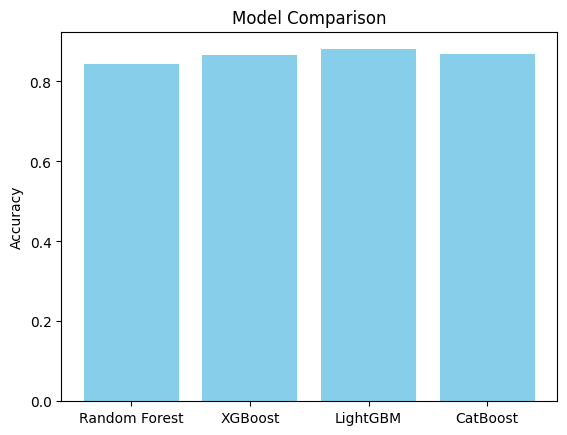

In [83]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(depth=4, iterations=100,  random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")
    # print(classification_report(y_test, y_pred))

# Show comparison
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

In [ ]:
##Train & Evaluate Models
#We will train four models and compare their performances.

In [ ]:
#Visualize Model Performances

In [ ]:
#Step 7: Explainability with SHAP (XAI)

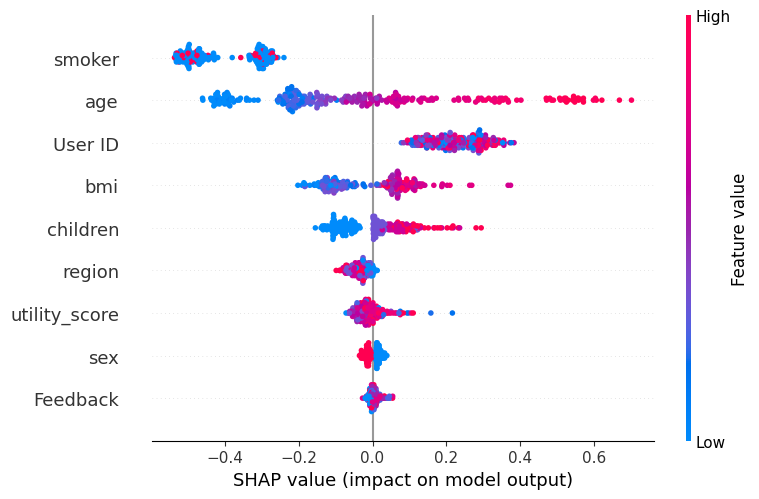

In [26]:
# Select the best model
final_model = results[best_model]

# Ensure X_train and X_test are in the correct format (SHAP requires raw features)
X_train_shap = pd.DataFrame(scaler.inverse_transform(X_train), columns=X.columns)
X_test_shap = pd.DataFrame(scaler.inverse_transform(X_test), columns=X.columns)

# Choose SHAP explainer based on model type
if best_model in ['Random Forest', 'XGBoost']:
    explainer = shap.TreeExplainer(final_model)  # For tree-based models
elif best_model == 'MLP Regressor':
    explainer = shap.Explainer(final_model, X_train_shap)  # KernelExplainer for NN
else:
    explainer = shap.LinearExplainer(final_model, X_train_shap)  # For linear models

# Compute SHAP values
shap_values = explainer(X_test_shap)

# Summary Plot
shap.summary_plot(shap_values, X_test_shap)



In [28]:
final_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
#insurance recommendation_API

In [27]:
pip install fastapi uvicorn joblib scikit-learn pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.5 MB/s eta 0:00:00


In [30]:
from fastapi import FastAPI, HTTPException
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap
import xgboost as xgb
import lightgbm as lgb

app = FastAPI()

# Load dataset
df = pd.read_csv("augmented_ushealthinsurance.csv")

# Encode categorical variables
label_encoders = {}
categorical_columns = ["sex", "smoker", "region", "Insurance Company", "Feedback"]
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target
X = df.drop(columns=["User ID", "Insurance Company"])
y = df["Insurance Company"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (for SHAP consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Save models
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(lgb_model, "lgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")

# Function to recommend insurance policies
def recommend_insurance(user_input):
    input_df = pd.DataFrame([user_input])

    # Ensure categorical encoding matches training data
    for col, le in label_encoders.items():
        if col in input_df:
            if input_df[col].values[0] in le.classes_:  # Handle unseen categories
                input_df[col] = le.transform(input_df[col])
            else:
                input_df[col] = -1  # Assign unseen categories a default value

    # Drop unnecessary columns
    input_df = input_df.drop(columns=["User ID"], errors='ignore')

    # Scale features
    input_df_scaled = scaler.transform(input_df)

    # Get predictions
    utility_scores = {
        "RandomForest": rf_model.predict_proba(input_df_scaled)[0],
        "XGBoost": xgb_model.predict_proba(input_df_scaled)[0],
        "LightGBM": lgb_model.predict_proba(input_df_scaled)[0],
    }

    # Find best recommendation
    best_model = max(utility_scores, key=lambda k: max(utility_scores[k]))
    best_recommendation = np.argmax(utility_scores[best_model])

    return label_encoders["Insurance Company"].inverse_transform([best_recommendation])[0], best_model

@app.post("/recommend")
def get_recommendation(user_input: dict):
    try:
        recommendation, model_used = recommend_insurance(user_input)
        return {"recommended_insurance": recommendation, "model_used": model_used}
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

# SHAP Explainability
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)

@app.get("/explain")
def explain_prediction():
    feature_importance = pd.DataFrame(
        {"Feature": X.columns, "SHAP Value": np.mean(np.abs(shap_values), axis=0)}
    ).sort_values(by="SHAP Value", ascending=False)

    return feature_importance.to_dict(orient="records")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 8
[LightGBM] [Info] Start training from score -1.486476
[LightGBM] [Info] Start training from score -1.637876
[LightGBM] [Info] Start training from score -1.738972
[LightGBM] [Info] Start training from score -1.637876
[LightGBM] [Info] Start training from score -1.563768


In [ ]:
### or recommendation model/function

In [31]:
# Function to recommend insurance policies
def recommend_insurance(user_data):
    # Convert user input to DataFrame
    user_df = pd.DataFrame([user_data])

    # --- Apply feedback mapping to the user_df ---
    user_df['Feedback'] = user_df['Feedback'].map(feedback_mapping)

    # Encode categorical columns
    for col in categorical_cols:
        if col in label_encoders:  # Ensure encoder exists
            user_df[col] = user_df[col].map(lambda x: label_encoders[col].classes_.tolist().index(x) if x in label_encoders[col].classes_ else -1)
        else:
            print(f"Warning: {col} was not in the training data!")

    # Normalize numerical columns (ensure correct shape)
    numeric_cols = ['age', 'bmi', 'children', 'charges']
    user_df[numeric_cols] = scaler.transform(user_df[numeric_cols])

    # Calculate utility score
    predicted_utility = calculate_utility(user_df.iloc[0])  # Using existing function

    # Recommend top 3 insurance companies based on highest utility scores
    recommendations = df[['Insurance Company', 'utility_score']].sort_values(by='utility_score', ascending=False).head(3)

    return predicted_utility, recommendations
